In [1]:
import pymatgen
from pymatgen.ext.matproj import MPRester
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Composition
import re
import pprint
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
import logging
m = MPRester("Z51OJasyeWwk4pci") #use API key generated in Materials Project Dashboard

C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\ext\matproj.py:179: UserWarning: You are using the legacy MPRester, which is deprecated. If you are not a power user, ie., you do not have a lot of legacy code that uses many different MPRester methods, it is recommended you get a new API key from the new Materials Project front end. Once you use get your new API key, using the new API key will automatically route you to using the new MPRester.
  warnings.warn(


In [2]:
#query the MP database for binary materials with 1:1 stoichiometry
anon_formula = {'A':1, 'B':1}
binary = m.query(criteria = {'anonymous_formula':anon_formula, 'icsd_ids':{'$gte':0}}, properties = ['pretty_formula', 'material_id', 'spacegroup.symbol', 'spacegroup.crystal_system', 'icsd_ids', 'e_above_hull', 'band_gap'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2201/2201 [00:02<00:00, 836.35it/s]


In [3]:
#Keeping only the lowest energy structures for each material
binary_df = pd.DataFrame(binary)
df = binary_df.sort_values(['pretty_formula', 'e_above_hull'])
df = df.reset_index(drop = True)
df = df.drop_duplicates('pretty_formula', keep = 'first')
df = df.reset_index(drop=True)

In [4]:
df['spacegroup.crystal_system'].value_counts()

cubic           613
orthorhombic    282
hexagonal       120
tetragonal      118
monoclinic       50
trigonal         33
triclinic         5
Name: spacegroup.crystal_system, dtype: int64

In [5]:
df.to_csv('Binary_materials.csv')

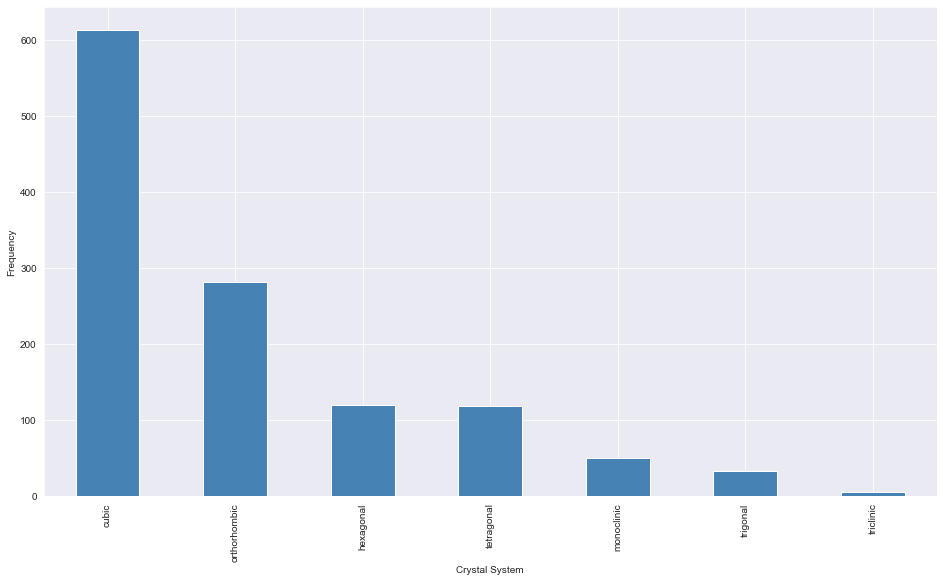

In [6]:
ax =df['spacegroup.crystal_system'].value_counts().plot(kind='bar', figsize = (16,9), color = 'steelblue')
ax.set_xlabel('Crystal System')
ax.set_ylabel('Frequency')
plt.savefig('Crystal_systems.pdf')

In [7]:
#function to return cation oxidation state
def cat_os(x):
    comp = Composition(x)
    os = comp.oxi_state_guesses()
    if len(os) > 0:
        oxidation_states = list(os[0].values())
    else:
        oxidation_states = [0,0]

    return oxidation_states[0]

#function to return anion oxidation state

def an_os(x):
    comp = Composition(x)
    os = comp.oxi_state_guesses()
    if len(os) > 0:
        oxidation_states = list(os[0].values())
    else:
        oxidation_states = [0,0]

    return oxidation_states[1]

In [8]:
df['cation_oxidation_state'] = df['pretty_formula'].apply(cat_os)
df['anion_oxidation_state'] = df['pretty_formula'].apply(an_os)
df

,pretty_formula,material_id,spacegroup.symbol,spacegroup.crystal_system,icsd_ids,e_above_hull,band_gap,cation_oxidation_state,anion_oxidation_state
0,AgBr,mp-23231,Fm-3m,cubic,"[56548, 56547, 65061, 53850, 56546, 52246, 650...",0.037294,0.7946,1.0,-1.0
1,AgC,mp-1008653,Fm-3m,cubic,[183175],2.235510,0.0000,2.0,-2.0
2,AgCl,mp-22922,Fm-3m,cubic,"[56540, 56539, 157535, 56538, 64734]",0.000000,1.2003,1.0,-1.0
3,AgF,mp-7592,Fm-3m,cubic,[18008],0.000000,0.0000,1.0,-1.0
4,AgI,mp-22925,F-43m,cubic,"[164964, 52361, 164960, 164965, 53851, 161579,...",0.000000,1.7236,1.0,-1.0
...,...,...,...,...,...,...,...,...,...
1216,ZrS,mp-7859,P4/nmm,tetragonal,[24754],0.000000,0.0000,2.0,-2.0
1217,ZrSb,mp-569671,P2_13,cubic,[107692],0.000000,0.0000,3.0,-3.0
1218,ZrSi,mp-893,Pnma,orthorhombic,"[652609, 16771, 652613, 43245]",0.000000,0.0000,4.0,-4.0
1219,ZrTe,mp-1539,P-6m2,hexagonal,"[653218, 410867, 657484, 653209]",0.000000,0.0000,2.0,-2.0


In [9]:
#dropping the compositions with no oxidation states (cation_oxidation_state = 0)
df = df[df.cation_oxidation_state != 0]
df = df.reset_index(drop=True)

In [10]:
#function to estimate coordination numbers
from pymatgen.analysis.local_env import CrystalNN
def co_ordination_num(y):
  structure = m.get_structure_by_material_id(y)
  crystal = CrystalNN()
  cn = crystal.get_cn(structure, 0)
  return cn

In [11]:
from tqdm import tqdm
tqdm.pandas()
df['coordination_number'] = df['material_id'].progress_apply(co_ordination_num)

  0%|                                                                                                                                                                                                                          | 0/517 [00:00<?, ?it/s]C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:4121: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
C:\Users\ashis\AppData\Local\Programs\Python\Python310\lib\site-packages\pymatgen\analysis\local_env.py:3924: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 517/517 [01:57<00:00,  4.

In [12]:
df.to_csv('rr_rules_dataset.csv')